In [3]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [5]:
df = pd.read_excel('online_retail.xlsx')

print(df.info())
print(df.describe())
print(df.isnull().sum())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB
None
            Quantity                    InvoiceDate          Price  \
count  525461.000000                         525461  525461.000000   
mean       10.337667  2010-06-28 11:37:36.845017856       4.688834   
min     -9600.000000            2009-12-01 07:45:00  -53594.360000   
25%         1.000000   

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [8]:
df.dropna(subset=["Customer ID"], inplace=True)
df = df[df['Quantity'] > 0]
df = df[df['Price'] > 0]

df["totalprice"] = df["Quantity"] * df["Price"]

df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

df.head()


KeyError: ['Customer ID']

In [27]:
top_products = df.groupby('description')['totalprice'].sum().sort_values(ascending=False).head(10).reset_index()

fig = px.bar(top_products,
             x='totalprice',
             y='description',
             orientation='h',
             title='💸 Топ-10 товаров по выручке',
             labels={'description': 'Товар', 'totalprice': 'Общая выручка (€)'},
             color='totalprice',
             color_continuous_scale='Viridis')

fig.update_layout(yaxis={'categoryorder': 'total ascending'})
fig.show()


<class 'pandas.core.frame.DataFrame'>
Index: 400916 entries, 0 to 525460
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   invoice      400916 non-null  object        
 1   stockcode    400916 non-null  object        
 2   description  400916 non-null  object        
 3   quantity     400916 non-null  int64         
 4   invoicedate  400916 non-null  datetime64[ns]
 5   price        400916 non-null  float64       
 6   customer_id  400916 non-null  float64       
 7   country      400916 non-null  object        
 8   totalprice   400916 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 30.6+ MB
None
            quantity                    invoicedate          price  \
count  400916.000000                         400916  400916.000000   
mean       13.767418  2010-07-01 05:01:16.167027712       3.305826   
min         1.000000            2009-12-01 07:45

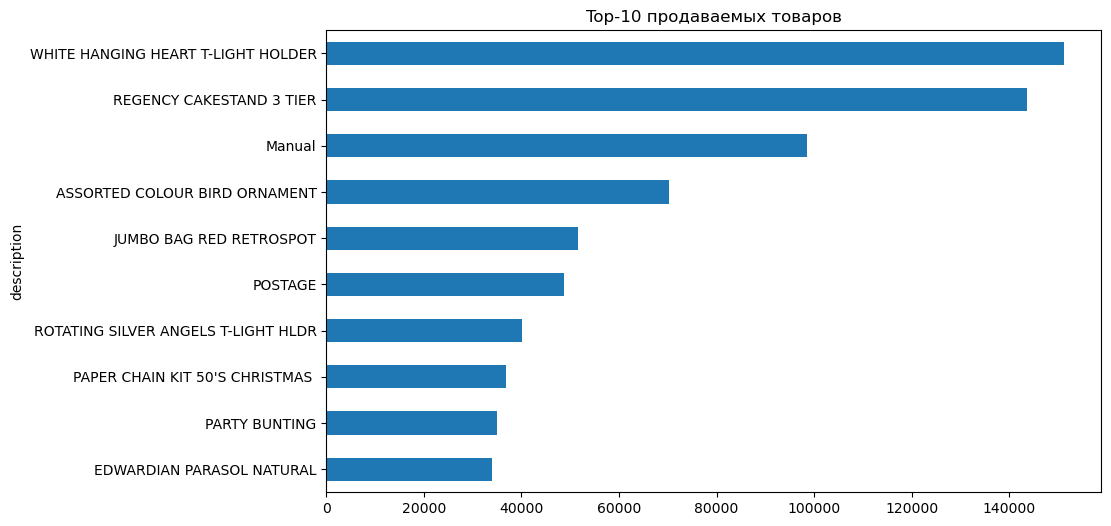

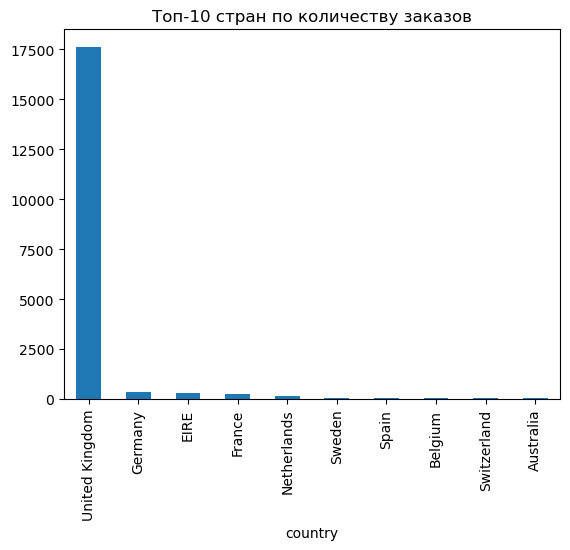

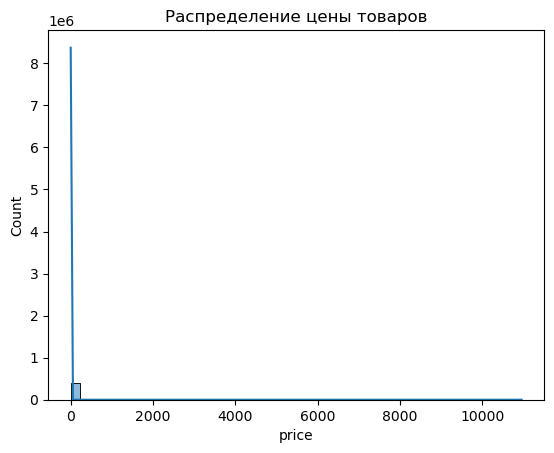

In [29]:
top_countries = df.groupby('country')['totalprice'].sum().sort_values(ascending=False).head(10).reset_index()

fig = px.bar(top_countries,
             x='country',
             y='totalprice',
             title='🌍 Топ-10 стран по выручке',
             labels={'country': 'Страна', 'totalprice': 'Общая выручка (€)'},
             color='totalprice')

fig.show()


In [31]:
fig = px.histogram(df[df['price'] < 100],
                   x='price',
                   nbins=50,
                   title='📈 Распределение цен на товары',
                   labels={'price': 'Цена (€)'},
                   color_discrete_sequence=['indianred'])

fig.show()


,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
customer_id,,,,,,,,
12346.0,165,11,372.86,1,4,2,142,7
12347.0,3,2,1323.32,4,2,3,423,9
12348.0,74,1,222.16,2,1,1,211,4
12349.0,43,3,2671.14,3,3,4,334,10
12351.0,11,1,300.93,4,1,1,411,6


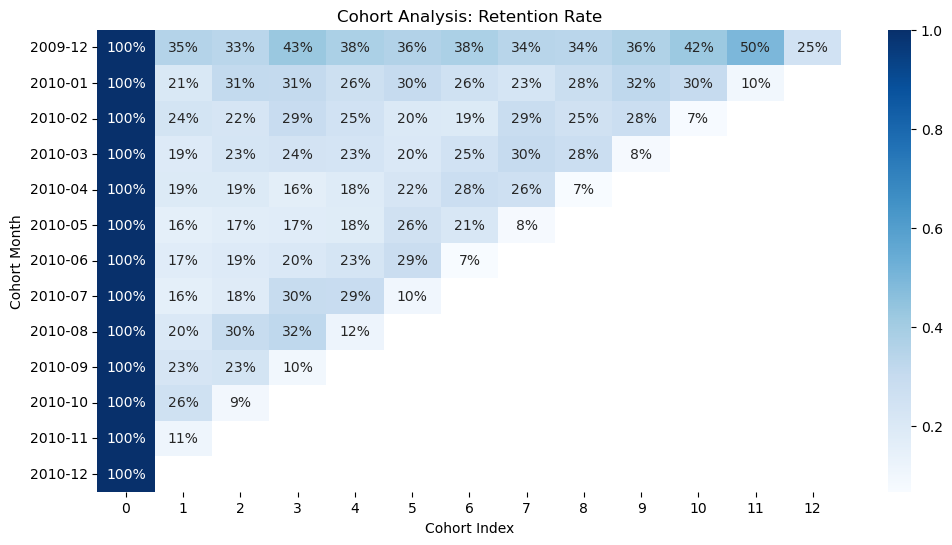

In [33]:
latest_date = df['invoicedate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('customer_id').agg({
    'invoicedate': lambda x: (latest_date - x.max()).days,
    'invoice': 'nunique',
    'totalprice': 'sum'
}).reset_index()

rfm.columns = ['customer_id', 'recency', 'frequency', 'monetary']

rfm['r'] = pd.qcut(rfm['recency'], 4, labels=[4,3,2,1]).astype(int)
rfm['f'] = pd.qcut(rfm['frequency'].rank(method='first'), 4, labels=[1,2,3,4]).astype(int)
rfm['m'] = pd.qcut(rfm['monetary'], 4, labels=[1,2,3,4]).astype(int)

rfm['RFM_Score'] = rfm[['r','f','m']].sum(axis=1)


In [ ]:
rfm['segment'] = pd.cut(rfm['RFM_Score'], 
                        bins=[0, 4, 7, 10, 12], 
                        labels=['🛑 Ушли', '⚠️ Реанимация', '😊 Лояльные', '🟢 ТОП-клиенты'])

segment_counts = rfm['segment'].value_counts().reset_index()
segment_counts.columns = ['Сегмент', 'Количество клиентов']

fig = px.pie(segment_counts,
             names='Сегмент',
             values='Количество клиентов',
             title='👥 Сегментация клиентов по RFM-анализу',
             color_discrete_sequence=px.colors.qualitative.Set3)

fig.show()


In [ ]:
df['cohort_month'] = df['invoicedate'].apply(lambda x: dt.datetime(x.year, x.month, 1))
df['order_month'] = df.groupby('customer_id')['invoicedate'].transform('min').apply(lambda x: dt.datetime(x.year, x.month, 1))
df['cohort_index'] = ((df['cohort_month'].dt.year - df['order_month'].dt.year) * 12 +
                      (df['cohort_month'].dt.month - df['order_month'].dt.month) + 1)

cohort_data = df.groupby(['order_month', 'cohort_index'])['customer_id'].nunique().reset_index()
cohort_pivot = cohort_data.pivot(index='order_month', columns='cohort_index', values='customer_id')

retention = cohort_pivot.divide(cohort_pivot.iloc[:,0], axis=0)


In [ ]:
fig = go.Figure(data=go.Heatmap(
    z=retention.T.values,
    x=retention.columns,
    y=retention.index.astype(str),
    colorscale='Blues',
    text=np.round(retention.T.values*100, 1).astype(str) + '%',
    hoverinfo='text'))

fig.update_layout(
    title='📆 Cohort-анализ: удержание клиентов',
    xaxis_title='Месяц с момента первой покупки',
    yaxis_title='Когорта (месяц первой покупки)'
)

fig.show()
